# Leagues Comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import networkx as nx
from collections import Counter

data_partite = pd.read_csv("data_1/data_matches.csv", encoding='latin-1')
campionati = pd.read_csv("data_1/leagues.csv", encoding='latin-1')

In [2]:
def transformation(dataset, column, retain, new_col_names):
    new_data = dataset.merge(campionati, left_on= column, right_on = "Squad", how='outer').fillna(0)
    new_data = new_data[(new_data['League'] != 0) & (new_data[column] != 0)]
    new_data = new_data[retain]
    new_data.columns = new_col_names
    new_data['DR'] = new_data['DR'].apply(lambda x: int(x))
    new_data = new_data.reset_index()
    new_data = new_data.drop(['index'],axis = 1)
    return new_data

df3 = transformation(data_partite, 'Home_Team', ["League","Away_Team","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df4 = transformation(df3, "Away_Team", ["Home_Team","League","Winner","DR"], ['Home_Team',"Away_Team","Winner","DR"])
df5 = transformation(df4, "Winner", ["Home_Team","Away_Team","League","DR"], ['Home_League',"Away_League","Winner","DR"])

df5 = df5[df5["Home_League"] != df5["Away_League"]]
df5 = df5.reset_index()
df5 = df5.drop(['index'],axis = 1)

In [3]:
listone = [(df5['Home_League'][i], df5['Away_League'][i]) for i in range(len(df5))]
hh = Counter(listone).most_common()

nuova_lista = {}

for i in range(len(hh)):
    if (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) not in nuova_lista.keys()):
        nuova_lista[hh[i][0]] = hh[i][1]
    elif (hh[i][0] not in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[(hh[i][0][1], hh[i][0][0])] += hh[i][1]
    elif (hh[i][0] in nuova_lista.keys()) & ((hh[i][0][1], hh[i][0][0]) in nuova_lista.keys()):
        nuova_lista[hh[i][0]] += hh[i][1]

In [4]:
df_a = pd.DataFrame(index = df5.Home_League.unique(),columns = df5.Home_League.unique())
df_a = df_a.fillna(0)

nazioni = df5.Home_League.unique()

for i in range(len(df5)):
    a = Counter(df5.iloc[i][:3].values)
    rev = {v: k for k, v in a.items()}
    loser = rev[1]
    df_a[df5.iloc[i]['Winner']][loser] += df5.iloc[i][3]
    
for i in range(len(list(nuova_lista.keys()))):
    df_a.loc[list(nuova_lista.keys())[i][0],list(nuova_lista.keys())[i][1]] /= nuova_lista[list(nuova_lista.keys())[i]]
    df_a.loc[list(nuova_lista.keys())[i][1],list(nuova_lista.keys())[i][0]] /= nuova_lista[list(nuova_lista.keys())[i]]
    
v = pd.DataFrame(columns = ['vincente',"perdente","di quanto"])
for k in range(len(df_a)):
    for j in range(len(df_a)):
        v = v.append({'vincente': df_a.index[k],'perdente': df_a[df_a.index[k]].index[j],'di quanto':df_a[df_a.index[k]][j]}, ignore_index = True)

v = v[v['vincente'] != v['perdente']]

In [5]:
a = list(set([i for i in v['vincente']]))
b = list(set([i for i in v['perdente']]))
c = list(set(a+b))
subset = v[['perdente', 'vincente','di quanto']]
tuples = [tuple(x) for x in subset.to_numpy()]
tuples = [x for x in tuples if x[2] != 0] 

G = nx.DiGraph()
G.add_nodes_from(c)
G.add_weighted_edges_from(tuples)
G.in_edges(data=True)

InEdgeDataView([('Swiss Super League', 'Turkish League', {'weight': 0.5}), ('Ligue 1', 'Turkish League', {'weight': 0.4375}), ('Premier League', 'Turkish League', {'weight': 0.2857142857142857}), ('Cypro League', 'Turkish League', {'weight': 1.5}), ('Serie A', 'Turkish League', {'weight': 0.42857142857142855}), ('Bundesliga', 'Turkish League', {'weight': 0.42105263157894735}), ('Denmark League', 'Turkish League', {'weight': 1.0}), ('Divizia Nasional', 'Turkish League', {'weight': 1.0}), ('Ukraine League', 'Turkish League', {'weight': 0.46153846153846156}), ('Eredivisie', 'Turkish League', {'weight': 0.5625}), ('Czech League', 'Turkish League', {'weight': 2.0}), ('Belgian League', 'Turkish League', {'weight': 0.8461538461538461}), ('Bulgarian League', 'Turkish League', {'weight': 1.0}), ('Liga Portuguesa', 'Turkish League', {'weight': 0.5}), ('La Liga', 'Turkish League', {'weight': 0.05}), ('Russian League', 'Turkish League', {'weight': 0.47058823529411764}), ('Belarus League', 'Turkish

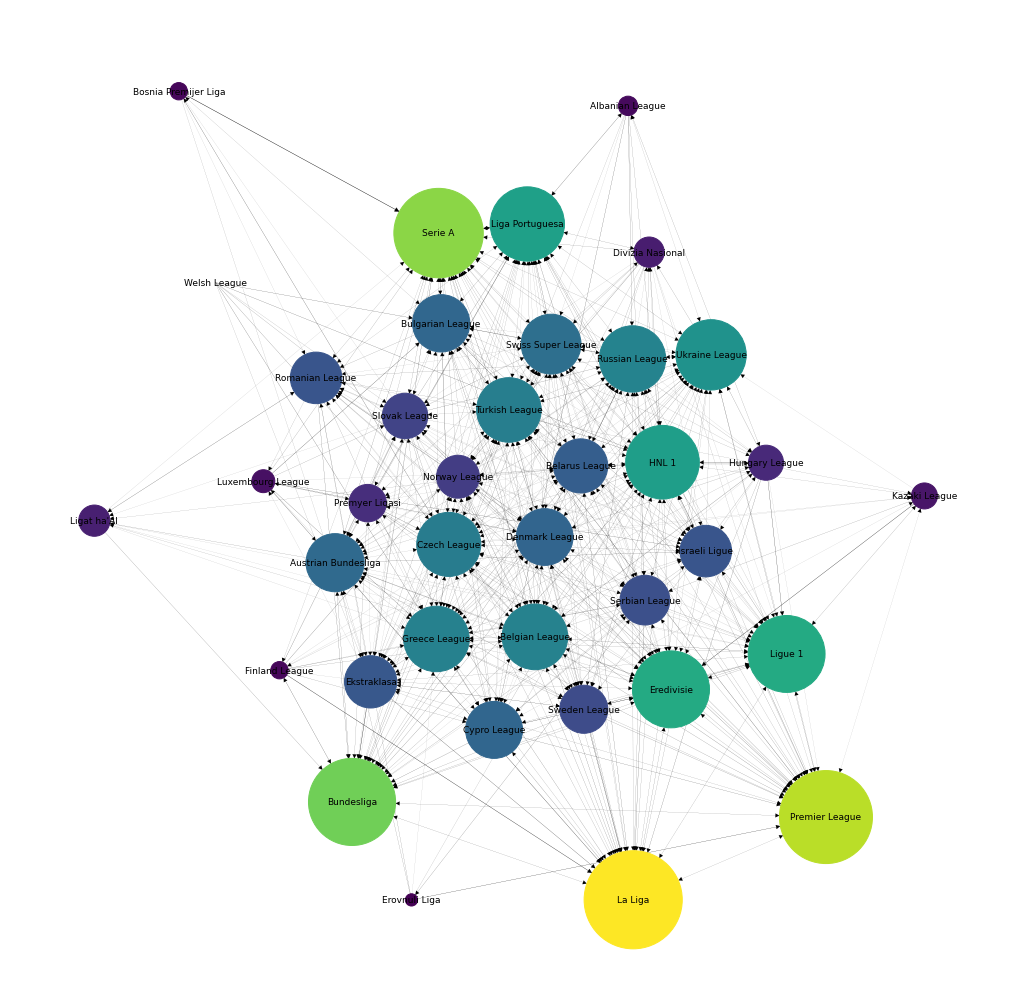

In [6]:
pos = nx.spring_layout(G, weight = 'weight', iterations=50000, threshold=0.000001)

node_size = [150 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
node_color = [50 * G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
weights = [G[i][j]['weight'] * 0.05 for i,j in G.edges()]

plt.figure(figsize = (18,18))
           
nx.draw_networkx(G, 
                 pos,
                 with_labels = False,
                 node_color = node_color,
                 node_size = node_size, 
                 width = weights)

nx.draw_networkx_labels(G, pos = pos, font_color = "black", font_size = 9)

plt.box(on = None)
plt.axis('off')

plt.show()

In [7]:
lista_j = [[i, G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))])] for i in G]
lista_j = [j for j in lista_j if ~np.isnan(j[1])]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

X = [G.in_degree(i) * np.mean([k[2]['weight'] for k in list(G.in_edges(i,data = True))]) for i in G]
X = [j for j in X if ~np.isnan(j)]
X.append(0)

scaled_x = NormalizeData(X)

y = [[lista_j[i][0], scaled_x[i]] for i in range(len(lista_j))]

diz={}

for i in range(len(y)):
    diz[y[i][0]] = y[i][1]
    
diz = {k: v for k, v in sorted(diz.items(), key=lambda item: item[1], reverse=True)}
diz

{'La Liga': 1.0,
 'Premier League': 0.8982607461097232,
 'Serie A': 0.8300297363167998,
 'Bundesliga': 0.7876546461399606,
 'Eredivisie': 0.6151174428660068,
 'Ligue 1': 0.6140089636557122,
 'Liga Portuguesa': 0.5731314385753985,
 'HNL 1': 0.5626121164797088,
 'Ukraine League': 0.5131584033772475,
 'Russian League': 0.45704917919352417,
 'Belgian League': 0.44706923390609216,
 'Greece League': 0.4454213872577271,
 'Turkish League': 0.43283976589002265,
 'Czech League': 0.42604562377117794,
 'Swiss Super League': 0.3715489272319347,
 'Austrian Bundesliga': 0.3503189879344409,
 'Bulgarian League': 0.3410379468383694,
 'Cypro League': 0.3368529047950675,
 'Denmark League': 0.3344662678505183,
 'Belarus League': 0.3040973240179713,
 'Ekstraklasa': 0.2837215796516897,
 'Romanian League': 0.2757037604813364,
 'Israeli Ligue': 0.27565147761263303,
 'Serbian League': 0.2562460398361926,
 'Sweden League': 0.23977779545798522,
 'Slovak League': 0.21395458597533157,
 'Norway League': 0.1910989847

In [8]:
second_ranking = pd.read_csv('data_1/SPI_Index.csv')

diz2={}

for i in range(len(second_ranking)):
    diz2[second_ranking['League'][i]] = second_ranking['Average SPI'][i]
    
diz2

{'Premier League': 1.0,
 'La Liga': 0.957068635493574,
 'Bundesliga': 0.9468143286847144,
 'Serie A': 0.8779053869291769,
 'Ligue 1': 0.8314191960623462,
 'Liga Portuguesa': 0.7153404429860541,
 'Eredivisie': 0.7038556193601312,
 'Brasileiro Série A': 0.6743232157506153,
 'Mexican Primera Division Torneo Clausura': 0.6486190866830736,
 'Russian League': 0.6253759912496583,
 'English League Championship': 0.6028165162701669,
 'Austrian Bundesliga': 0.5905113480995351,
 'Belgian League': 0.5854525567404977,
 'Turkish League': 0.5456658463221219,
 'Swiss Super League': 0.5410172272354389,
 'Denmark League': 0.5392398140552365,
 'MLS': 0.5385561936013126,
 'Argentina Primera Division': 0.5314465408805031,
 'Scottish Premiership': 0.5243368881596937,
 'Japanese J League': 0.485233798195242,
 'German 2. Bundesliga': 0.4830462127426852,
 'Greece League': 0.4681432868471425,
 'Norway League': 0.4502324309543341,
 'Italy Serie B': 0.4364232977850698,
 'Spanish Segunda Division': 0.4350560568772

In [9]:
nuovo1 = pd.DataFrame.from_dict(diz, orient='index')
nuovo1 = nuovo1.reset_index()
nuovo2 = pd.DataFrame.from_dict(diz2, orient='index')
nuovo2 = nuovo2.reset_index()
nuovo3 = pd.merge(nuovo1, nuovo2, on = "index")
nuovo3.columns = ["League","Graph Index", "SPI Index"]

nuovo3['Tot Index'] = (nuovo3['SPI Index'] + nuovo3['Graph Index'])/2

valore_nuovo = [i for i in nuovo3['Tot Index']]
valore_nuovo.append(0)
scaled_tot = NormalizeData(valore_nuovo)

y = [[nuovo3['League'][i], scaled_tot[i]] for i in range(len(nuovo3['League']))]

diz3 = {}

for i in range(len(y)):
    diz3[y[i][0]] = y[i][1]
    
diz3 = {k: v for k, v in sorted(diz3.items(), key=lambda item: item[1], reverse=True)}
diz3

{'La Liga': 1.0,
 'Premier League': 0.9698213090800933,
 'Bundesliga': 0.8862724128406507,
 'Serie A': 0.8727066400187562,
 'Ligue 1': 0.738585350911862,
 'Eredivisie': 0.6739616225710062,
 'Liga Portuguesa': 0.6583801759965983,
 'Russian League': 0.5530983509127341,
 'Belgian League': 0.5275971379486687,
 'Turkish League': 0.4999947154966354,
 'Austrian Bundesliga': 0.4807526858424141,
 'Greece League': 0.4668055606224497,
 'Swiss Super League': 0.4663056006092724,
 'Denmark League': 0.4464517433288841,
 'Norway League': 0.32771910121440606,
 'Sweden League': 0.31926042764035684}